<a href="https://colab.research.google.com/github/vitosilver99/CI2024_lab0/blob/main/STEP_4B_PIDNET_weighted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Dependencies

## Upload .zip files

For this step you must have the zip files in your Drive into a folder called `AML_project`

In [27]:
!pip install torchmetrics
!pip install fvcore

In [28]:
from google.colab import drive
import os

!git clone -b angelo_albumentations --single-branch https://github.com/AngeloBongiorno/AML_2025_project4.git

!cp AML_2025_project4/utils.py .

drive.mount('/content/drive')

fatal: destination path 'AML_2025_project4' already exists and is not an empty directory.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import importlib
import utils  # Replace with the actual module name

importlib.reload(utils)

<module 'utils' from '/content/utils.py'>

In [30]:
import tqdm

from utils import get_loveDA

paths = get_loveDA(verbose=True)
print(paths)

TRAINING_PATH_URBAN = paths["training_urban"]
TRAINING_PATH_RURAL = paths["training_rural"]
VAL_PATH_URBAN = paths["validation_urban"]
VAL_PATH_RURAL = paths["validation_rural"]

Skipping extraction for the dataset, already extracted.
{'training_urban': '/content/dataset/Train/Urban', 'training_rural': '/content/dataset/Train/Rural', 'validation_urban': '/content/dataset/Val/Urban', 'validation_rural': '/content/dataset/Val/Rural'}


In [31]:
SEM_CLASSES = [
    'background',
    'building',
    'road',
    'water',
    'barren',
    'forest',
    'agriculture'
]

NUM_CLASSES = len(SEM_CLASSES)

sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(SEM_CLASSES)}

IGNORE_INDEX = -1

RESIZE = 512

BATCH_SIZE = 16

EPOCHS = 20

SEED = 42

STEP_SIZE = 21

GAMMA = 0.5

LR = 0.000329658544839708

P = 0.5 # probabilità augmentation

ALPHA_TEACHER = 0.99

THRESHOLD = 0.9

MOMENTUM = 0.85

LOSS_TYPE = "ohem" # "ohem", "ce"

TYPE_WEIGHT = "inverse" # median-frequency | inverse | log

PIXEL_WEIGHT = "threshold_uniform" # "threshold_uniform", "threshold"


# Define and instantiate

### Define PIDnet

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=False):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        if self.no_relu:
            return out
        else:
            return self.relu(out)

class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=True):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        if self.no_relu:
            return out
        else:
            return self.relu(out)

class segmenthead(nn.Module):

    def __init__(self, inplanes, interplanes, outplanes, scale_factor=None):
        super(segmenthead, self).__init__()
        self.bn1 = BatchNorm2d(inplanes, momentum=bn_mom)
        self.conv1 = nn.Conv2d(inplanes, interplanes, kernel_size=3, padding=1, bias=False)
        self.bn2 = BatchNorm2d(interplanes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(interplanes, outplanes, kernel_size=1, padding=0, bias=True)
        self.scale_factor = scale_factor

    def forward(self, x):

        x = self.conv1(self.relu(self.bn1(x)))
        out = self.conv2(self.relu(self.bn2(x)))

        if self.scale_factor is not None:
            height = x.shape[-2] * self.scale_factor
            width = x.shape[-1] * self.scale_factor
            out = F.interpolate(out,
                        size=[height, width],
                        mode='bilinear', align_corners=algc)

        return out

class DAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(DAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.process1 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process2 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process3 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process4 = nn.Sequential(
                                    BatchNorm(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )
        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )

    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        x_list = []

        x_list.append(self.scale0(x))
        x_list.append(self.process1((F.interpolate(self.scale1(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[0])))
        x_list.append((self.process2((F.interpolate(self.scale2(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[1]))))
        x_list.append(self.process3((F.interpolate(self.scale3(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[2])))
        x_list.append(self.process4((F.interpolate(self.scale4(x),
                        size=[height, width],
                        mode='bilinear', align_corners=algc)+x_list[3])))

        out = self.compression(torch.cat(x_list, 1)) + self.shortcut(x)
        return out

class PAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes, BatchNorm=nn.BatchNorm2d):
        super(PAPPM, self).__init__()
        bn_mom = 0.1
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale0 = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )

        self.scale_process = nn.Sequential(
                                    BatchNorm(branch_planes*4, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes*4, branch_planes*4, kernel_size=3, padding=1, groups=4, bias=False),
                                    )


        self.compression = nn.Sequential(
                                    BatchNorm(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )

        self.shortcut = nn.Sequential(
                                    BatchNorm(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )


    def forward(self, x):
        width = x.shape[-1]
        height = x.shape[-2]
        scale_list = []

        x_ = self.scale0(x)
        scale_list.append(F.interpolate(self.scale1(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale2(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale3(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)
        scale_list.append(F.interpolate(self.scale4(x), size=[height, width],
                        mode='bilinear', align_corners=algc)+x_)

        scale_out = self.scale_process(torch.cat(scale_list, 1))

        out = self.compression(torch.cat([x_,scale_out], 1)) + self.shortcut(x)
        return out


class PagFM(nn.Module):
    def __init__(self, in_channels, mid_channels, after_relu=False, with_channel=False, BatchNorm=nn.BatchNorm2d):
        super(PagFM, self).__init__()
        self.with_channel = with_channel
        self.after_relu = after_relu
        self.f_x = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        self.f_y = nn.Sequential(
                                nn.Conv2d(in_channels, mid_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(mid_channels)
                                )
        if with_channel:
            self.up = nn.Sequential(
                                    nn.Conv2d(mid_channels, in_channels,
                                              kernel_size=1, bias=False),
                                    BatchNorm(in_channels)
                                   )
        if after_relu:
            self.relu = nn.ReLU(inplace=True)

    def forward(self, x, y):
        input_size = x.size()
        if self.after_relu:
            y = self.relu(y)
            x = self.relu(x)

        y_q = self.f_y(y)
        y_q = F.interpolate(y_q, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x_k = self.f_x(x)

        if self.with_channel:
            sim_map = torch.sigmoid(self.up(x_k * y_q))
        else:
            sim_map = torch.sigmoid(torch.sum(x_k * y_q, dim=1).unsqueeze(1))

        y = F.interpolate(y, size=[input_size[2], input_size[3]],
                            mode='bilinear', align_corners=False)
        x = (1-sim_map)*x + sim_map*y

        return x

class Light_Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Light_Bag, self).__init__()
        self.conv_p = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add


class DDFMv2(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(DDFMv2, self).__init__()
        self.conv_p = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )
        self.conv_i = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=1, bias=False),
                                BatchNorm(out_channels)
                                )

    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)

        p_add = self.conv_p((1-edge_att)*i + p)
        i_add = self.conv_i(i + edge_att*p)

        return p_add + i_add

class Bag(nn.Module):
    def __init__(self, in_channels, out_channels, BatchNorm=nn.BatchNorm2d):
        super(Bag, self).__init__()

        self.conv = nn.Sequential(
                                BatchNorm(in_channels),
                                nn.ReLU(inplace=True),
                                nn.Conv2d(in_channels, out_channels,
                                          kernel_size=3, padding=1, bias=False)
                                )


    def forward(self, p, i, d):
        edge_att = torch.sigmoid(d)
        return self.conv(edge_att*p + (1-edge_att)*i)

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import logging

BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1
algc = False



class PIDNet(nn.Module):

    def __init__(self, m=2, n=3, num_classes=19, planes=64, ppm_planes=96, head_planes=128, augment=True):
        super(PIDNet, self).__init__()
        self.augment = augment

        # I Branch
        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(BasicBlock, planes, planes, m)
        self.layer2 = self._make_layer(BasicBlock, planes, planes * 2, m, stride=2)
        self.layer3 = self._make_layer(BasicBlock, planes * 2, planes * 4, n, stride=2)
        self.layer4 = self._make_layer(BasicBlock, planes * 4, planes * 8, n, stride=2)
        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 2, stride=2)

        # P Branch
        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, planes * 2, kernel_size=1, bias=False),
                                          BatchNorm2d(planes * 2, momentum=bn_mom),
                                          )
        self.pag3 = PagFM(planes * 2, planes)
        self.pag4 = PagFM(planes * 2, planes)

        self.layer3_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer4_ = self._make_layer(BasicBlock, planes * 2, planes * 2, m)
        self.layer5_ = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # D Branch
        if m == 2:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes)
            self.layer4_d = self._make_layer(Bottleneck, planes, planes, 1)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = PAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Light_Bag(planes * 4, planes * 4)
        else:
            self.layer3_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.layer4_d = self._make_single_layer(BasicBlock, planes * 2, planes * 2)
            self.diff3 = nn.Sequential(
                                        nn.Conv2d(planes * 4, planes * 2, kernel_size=3, padding=1, bias=False),
                                        BatchNorm2d(planes * 2, momentum=bn_mom),
                                        )
            self.diff4 = nn.Sequential(
                                     nn.Conv2d(planes * 8, planes * 2, kernel_size=3, padding=1, bias=False),
                                     BatchNorm2d(planes * 2, momentum=bn_mom),
                                     )
            self.spp = DAPPM(planes * 16, ppm_planes, planes * 4)
            self.dfm = Bag(planes * 4, planes * 4)

        self.layer5_d = self._make_layer(Bottleneck, planes * 2, planes * 2, 1)

        # Prediction Head
        if self.augment:
            self.seghead_p = segmenthead(planes * 2, head_planes, num_classes)
            self.seghead_d = segmenthead(planes * 2, planes, 1)

        self.final_layer = segmenthead(planes * 4, head_planes, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)

    def _make_single_layer(self, block, inplanes, planes, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layer = block(inplanes, planes, stride, downsample, no_relu=True)

        return layer

    def forward(self, x):

        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.relu(self.layer2(self.relu(x)))
        x_ = self.layer3_(x)
        x_d = self.layer3_d(x)

        x = self.relu(self.layer3(x))
        x_ = self.pag3(x_, self.compression3(x))
        x_d = x_d + F.interpolate(
                        self.diff3(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_p = x_

        x = self.relu(self.layer4(x))
        x_ = self.layer4_(self.relu(x_))
        x_d = self.layer4_d(self.relu(x_d))

        x_ = self.pag4(x_, self.compression4(x))
        x_d = x_d + F.interpolate(
                        self.diff4(x),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)
        if self.augment:
            temp_d = x_d

        x_ = self.layer5_(self.relu(x_))
        x_d = self.layer5_d(self.relu(x_d))
        x = F.interpolate(
                        self.spp(self.layer5(x)),
                        size=[height_output, width_output],
                        mode='bilinear', align_corners=algc)

        x_ = self.final_layer(self.dfm(x_, x, x_d))

        if self.augment:
            x_extra_p = self.seghead_p(temp_p)
            x_extra_d = self.seghead_d(temp_d)
            return [x_extra_p, x_, x_extra_d]
        else:
            return x_

def get_seg_model(cfg, imgnet_pretrained):

    if 's' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=32, ppm_planes=96, head_planes=128, augment=True)
    elif 'm' in cfg.MODEL.NAME:
        model = PIDNet(m=2, n=3, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=96, head_planes=128, augment=True)
    else:
        model = PIDNet(m=3, n=4, num_classes=cfg.DATASET.NUM_CLASSES, planes=64, ppm_planes=112, head_planes=256, augment=True)

    if imgnet_pretrained:
        pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']
        model_dict = model.state_dict()
        pretrained_state = {k: v for k, v in pretrained_state.items() if (k in model_dict and v.shape == model_dict[k].shape)}
        model_dict.update(pretrained_state)
        msg = 'Loaded {} parameters!'.format(len(pretrained_state))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model.load_state_dict(model_dict, strict = False)
    else:
        pretrained_dict = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')
        if 'state_dict' in pretrained_dict:
            pretrained_dict = pretrained_dict['state_dict']
        model_dict = model.state_dict()
        pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items() if (k[6:] in model_dict and v.shape == model_dict[k[6:]].shape)}
        msg = 'Loaded {} parameters!'.format(len(pretrained_dict))
        logging.info('Attention!!!')
        logging.info(msg)
        logging.info('Over!!!')
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict, strict = False)

    return model

def get_pred_model(name, num_classes):

    if 's' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=32, ppm_planes=96, head_planes=128, augment=False)
    elif 'm' in name:
        model = PIDNet(m=2, n=3, num_classes=num_classes, planes=64, ppm_planes=96, head_planes=128, augment=False)
    else:
        model = PIDNet(m=3, n=4, num_classes=num_classes, planes=64, ppm_planes=112, head_planes=256, augment=False)

    return model

# Dataset & dataloader

## Dataset definition

In [34]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
from albumentations.pytorch import ToTensorV2

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform, target=False):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))
        self.target = target

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        # Read an image with OpenCV
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)

        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        mask_np = np.array(mask)

        edge = cv2.Canny(mask_np, 0.1, 0.2)

        kernel = np.ones((3, 3), np.uint8)  # Kernel for dilation

        edge = edge[6:-6, 6:-6]
        edge = np.pad(edge, ((6,6),(6,6)), mode='constant')
        boundaries = cv2.dilate(edge, kernel, iterations=1)  # Dilate edges
        boundaries = (boundaries > 50) * 1.0 # boundaries matrix is float with 1.0 or 0.0

        mask = torch.as_tensor(np.array(mask), dtype=torch.int64) - 1

        boundaries_tensor = torch.as_tensor(boundaries, dtype=torch.float32)

        # if the dataset is a target dataset, does not return the mask
        if self.target == True:
          return image, boundaries_tensor
        return image, mask, boundaries_tensor

In [35]:
# Define transformations for images & masks
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import v2 as T
import cv2

resize_transform = A.Compose([
    A.Resize(height=RESIZE, width=RESIZE, p=1),
    A.ToFloat(),
    ToTensorV2()
])

# the best augmentation from previous step is chosen
augment = A.HueSaturationValue(
    hue_shift_limit=20,
    sat_shift_limit=30,
    val_shift_limit=20,
    p=P)

In [36]:
def extract_boundary_mask(mask):
    if isinstance(mask, torch.Tensor):
        mask_np = mask.squeeze().cpu().numpy()  # Assicura che sia [H, W]
    else:
        mask_np = np.array(mask)

    mask_np = mask_np.astype(np.uint8)

    edge = cv2.Canny(mask_np, 0.1, 0.2)

    kernel = np.ones((3, 3), np.uint8)
    edge = edge[6:-6, 6:-6]
    edge = np.pad(edge, ((6,6),(6,6)), mode='constant')
    boundaries = cv2.dilate(edge, kernel, iterations=1)
    boundaries = (boundaries > 50).astype(np.float32)

    boundaries_tensor = torch.from_numpy(boundaries).unsqueeze(0)  # shape: [1, H, W]
    return boundaries_tensor


## Dataset instantiation

In [37]:
# Create dataset objects

# TRAINING DATASETS
source_dataset = SegmentationDataset(TRAINING_PATH_URBAN + "/images_png", TRAINING_PATH_URBAN + "/masks_png",
                                    transform=resize_transform)


target_dataset = SegmentationDataset(TRAINING_PATH_RURAL + "/images_png", TRAINING_PATH_RURAL + "/masks_png",
                                    transform=resize_transform, target=True)

# EVALUATION DATASET

val_dataset = SegmentationDataset(VAL_PATH_RURAL + "/images_png", VAL_PATH_RURAL + "/masks_png",
                                    transform=resize_transform)

In [38]:
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader

# Supponiamo tu abbia un DataLoader con le etichette GT (y) nei batch
class_counts = torch.zeros(NUM_CLASSES)

for (images, labels, _) in tqdm(DataLoader(source_dataset, batch_size=BATCH_SIZE)):
    for c in range(NUM_CLASSES):
        class_counts[c] += torch.sum(labels == c)

# Converti in numpy
class_counts = class_counts.numpy()
total_pixels = np.sum(class_counts)
frequencies = class_counts / total_pixels

if TYPE_WEIGHT == "inverse":
  #Inverse frequency
  class_weights = 1.0 / (frequencies + 1e-8)
elif TYPE_WEIGHT == "median-frequency":
  #Median frequency balancing
  median = np.median(frequencies)
  class_weights = median / (frequencies + 1e-8)
elif TYPE_WEIGHT == "log":
  #Log smoothing
  class_weights = 1.0 / np.log(1.02 + frequencies)

print(class_weights)

# class_weights = [0.16340506, 0.37345123, 0.85315025, 2.1215937,  1.0464315,  0.9999999, 4.2676406]
# [0.16340506 0.37345123 0.85315025 2.1215937  1.0464315  0.9999999 4.2676406]

100%|██████████| 73/73 [01:01<00:00,  1.19it/s]

[ 2.063954  4.717028 10.776062 26.797655 13.217381 12.630906 53.904175]


## Loader instantiation

In [39]:
# Create DataLoaders

# TRAINING DATALOADERS
source_loader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
target_loader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# EVALUATION DATALOADERS

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# enumerate dataloaders
source_loader_iter = enumerate(source_loader)
target_loader_iter = enumerate(target_loader)


### Instantiate model

In [40]:
import gdown

if (os.path.exists("./PIDNet_S_ImageNet.pth.tar") == False):
  url = "https://drive.google.com/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-"
  output = "./"
  gdown.download(url, output, quiet=False)

  print("imagenet-pretrained pidnet weights downloaded")


class Config:
  class MODEL:
      NAME = 'pidnet_s'
      PRETRAINED = 'PIDNet_S_ImageNet.pth.tar'
  class DATASET:
      NUM_CLASSES = NUM_CLASSES

cfg = Config()

model = get_seg_model(cfg, imgnet_pretrained=True)

# Training Phase

## Define loss functions

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Extra Semantic Loss (Classica CrossEntropy Loss)
class CrossEntropyLoss(nn.Module):
    def __init__(self, num_outputs, weight=None, balance_weights=[0.4, 1.0], sb_weights=1.0):
        super(CrossEntropyLoss, self).__init__()
        self.loss = nn.CrossEntropyLoss(weight=weight, ignore_index=IGNORE_INDEX)
        self.num_outputs = num_outputs
        self.balance_weights = balance_weights
        self.sb_weights = sb_weights

    def _forward(self, pred, target):
        return self.loss(pred, target)

    def forward(self, score, target):
        if self.num_outputs == 1:
            score = [score]

        if len(self.balance_weights) == len(score):
            return sum([w * self._forward(x, target) for (w, x) in zip(self.balance_weights, score)])
        elif len(score) == 1:
            return self.sb_weights * self._forward(score[0], target)
        else:
            raise ValueError("lengths of prediction and target are not identical!")

class OhemCrossEntropy(nn.Module):
    def __init__(self, thres=0.7, min_kept=26_000, balance_weights=[0.4, 1.0], sb_weights=1.0, weight=None):
        super(OhemCrossEntropy, self).__init__()
        self.thresh = thres
        self.min_kept = max(1, min_kept)
        self.ignore_label = IGNORE_INDEX
        self.balance_weights = balance_weights
        self.sb_weights = sb_weights
        self.criterion = nn.CrossEntropyLoss(
            weight=weight,
            ignore_index=self.ignore_label,
            reduction='none'
        )

    def _ce_forward(self, score, target):
        loss = self.criterion(score, target)
        return loss

    def _ohem_forward(self, score, target, **kwargs):
        pred = F.softmax(score, dim=1)
        pixel_losses = self.criterion(score, target).contiguous().view(-1)
        mask = target.contiguous().view(-1) != self.ignore_label

        tmp_target = target.clone()
        tmp_target[tmp_target == self.ignore_label] = 0
        pred = pred.gather(1, tmp_target.unsqueeze(1))
        pred, ind = pred.contiguous().view(-1,)[mask].contiguous().sort()
        min_value = pred[min(self.min_kept, pred.numel() - 1)]
        threshold = max(min_value, self.thresh)

        pixel_losses = pixel_losses[mask][ind]
        pixel_losses = pixel_losses[pred < threshold]
        return pixel_losses.mean()

    def forward(self, score, target):
        if not (isinstance(score, list) or isinstance(score, tuple)):
            score = [score]

        if len(self.balance_weights) == len(score):
            functions = [self._ce_forward] * \
                (len(self.balance_weights) - 1) + [self._ohem_forward]
            return sum([
                w * func(x, target)
                for (w, x, func) in zip(self.balance_weights, score, functions)
            ])

        elif len(score) == 1:
            return self.sb_weights * self._ohem_forward(score[0], target)

        else:
            raise ValueError("lengths of prediction and target are not identical!")


# Weighted Binary Cross Entropy per i bordi
def weighted_bce(bd_pre, target):
    n, c, h, w = bd_pre.size()
    log_p = bd_pre.permute(0,2,3,1).contiguous().view(1, -1)
    target_t = target.view(1, -1)

    pos_index = (target_t == 1)
    neg_index = (target_t == 0)

    weight = torch.zeros_like(log_p)
    pos_num = pos_index.sum()
    neg_num = neg_index.sum()
    sum_num = pos_num + neg_num
    weight[pos_index] = neg_num * 1.0 / sum_num
    weight[neg_index] = pos_num * 1.0 / sum_num

    loss = F.binary_cross_entropy_with_logits(log_p, target_t, weight, reduction='mean')

    return loss

class BondaryLoss(nn.Module):
    def __init__(self, coeff_bce = 20.0):
        super(BondaryLoss, self).__init__()
        self.coeff_bce = coeff_bce

    def forward(self, bd_pre, bd_gt):
        bce_loss = self.coeff_bce * weighted_bce(bd_pre, bd_gt)
        loss = bce_loss

        return loss

# PIDNet Loss Totale
class PIDNetLoss(nn.Module):
    def __init__(self, lambda_0=0.4, lambda_1=20, lambda_2=1, lambda_3=1, threshold=0.8, class_weights=None):
        super(PIDNetLoss, self).__init__()
        self.class_weights = class_weights
        if self.class_weights is not None:
            self.class_weights = torch.tensor(class_weights).cuda()
        if LOSS_TYPE == "ohem":
          self.sem_loss = OhemCrossEntropy(balance_weights=[lambda_0, lambda_2], sb_weights=lambda_3, weight = self.class_weights)
        else:
          self.sem_loss = CrossEntropyLoss(num_outputs=2, balance_weights=[lambda_0, lambda_2], sb_weights=lambda_3, weight = self.class_weights)
        self.bd_loss = BondaryLoss(coeff_bce=lambda_1)
        self.threshold = threshold

    def forward(self, pred_p, pred_main, target, boundary_head, boundary_mask):
        """
        pred_p: output branch P (B, C, H, W)
        pred_main: output principale (B, C, H, W)
        target: ground truth segmentazione (B, H, W)
        boundary_head: predizione dei bordi (B, 1, H, W)
        boundary_mask: ground truth dei bordi (B, 1, H, W)
        """

        loss_s = self.sem_loss([pred_p, pred_main], target) # l_0 e l_2
        loss_b = self.bd_loss(boundary_head, boundary_mask.unsqueeze(1)) # l_1

        # l_3
        filler = torch.ones_like(target) * IGNORE_INDEX
        bd_label = torch.where(F.sigmoid(boundary_head[:,0,:,:])>self.threshold, target, filler)
        loss_sb = self.sem_loss([pred_main], bd_label)


        loss = loss_s + loss_b + loss_sb


        return loss

In [42]:
class CrossEntropyLoss2dPixelWiseWeighted(nn.Module):
    def __init__(self, weight=None, ignore_index=250, reduction='none'):
        super(CrossEntropyLoss2dPixelWiseWeighted, self).__init__()
        self.CE =  nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index, reduction=reduction)

    def forward(self, output, target, pixelWiseWeight):
        loss = self.CE(output, target)
        loss = torch.mean(loss * pixelWiseWeight)
        return loss

## Upscaling function

In [43]:
import torch.nn.functional as F

def Upscaling(outputs, boundary_mask, model):
    """Upscale trough bilinear interpolation -> riporto le dimensioni dell'output a quelli originali
    Quindi passiamo da 64 x 64 della rete a 512 x 512"""

    h, w = boundary_mask.size(1), boundary_mask.size(2)
    ph, pw = outputs[0].size(2), outputs[0].size(3)
    if ph != h or pw != w:
        for i in range(len(outputs)):
            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)
    if model.augment:
        pred_p, pred_main, boundary_head = outputs  # P, I, D branches
    else:
        pred_p = None
        pred_main = outputs
        boundary_head = None  # Nessuna branch D se augment=False

    return pred_p, pred_main, boundary_head

## Instantiate discriminator, optimizers and schedulers

In [44]:
from torch.optim.lr_scheduler import LambdaLR, SequentialLR, StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=GAMMA, patience=3, threshold=0.01)

if TYPE_WEIGHT == "median-frequency" or TYPE_WEIGHT == "inverse" or TYPE_WEIGHT == "log":
  loss_fn = PIDNetLoss(threshold=0.8, class_weights=class_weights)
  mix_loss = CrossEntropyLoss2dPixelWiseWeighted(ignore_index = IGNORE_INDEX, weight = torch.tensor(class_weights).cuda())
else:
  loss_fn = PIDNetLoss(threshold=0.8, class_weights=None)
  mix_loss = CrossEntropyLoss2dPixelWiseWeighted(ignore_index = IGNORE_INDEX, weight = None)

print(device)

print(len(target_loader))
print(len(source_loader))

cuda
86
73


# Definition ema model

In [45]:
def create_ema_model(model):
    """Returns a new model that is used to generate pseudo-labels"""

    ema_model = get_seg_model(cfg, imgnet_pretrained=True)

    for param in ema_model.parameters():
        param.detach_()
    mp = list(model.parameters())
    mcp = list(ema_model.parameters())
    n = len(mp)
    for i in range(0, n):
        mcp[i].data[:] = mp[i].data[:].clone()

    return ema_model


def update_ema_variables(ema_model, model, alpha_teacher, iteration):
    # Use the "true" average until the exponential average is more correct
    alpha_teacher = min(1 - 1 / (iteration + 1), alpha_teacher)

    for ema_param, param in zip(ema_model.parameters(), model.parameters()):
        #ema_param.data.mul_(alpha).add_(1 - alpha, param.data)
        ema_param.data[:] = alpha_teacher * ema_param[:].data[:] + (1 - alpha_teacher) * param[:].data[:]
    return ema_model

In [46]:
def generate_class_mask(pred, classes):
    pred, classes = torch.broadcast_tensors(pred.unsqueeze(0), classes.unsqueeze(1).unsqueeze(2))
    N = pred.eq(classes).sum(0)
    return N

In [47]:
def oneMix(mask, data = None, target = None):
    #Mix
    if not (data is None):
        stackedMask0, _ = torch.broadcast_tensors(mask[0], data[0])
        data = (stackedMask0*data[0]+(1-stackedMask0)*data[1]).unsqueeze(0)
    if not (target is None):
        stackedMask0, _ = torch.broadcast_tensors(mask[0], target[0])
        target = (stackedMask0*target[0]+(1-stackedMask0)*target[1]).unsqueeze(0)
    return data, target

In [48]:
def strong_transform(target, masks_mix, aug = None, data = None):
    data, target = oneMix(masks_mix, data, target)

    if data is not None:
      data_np = data.squeeze(0).cpu().numpy()
    target_np = target.squeeze(0).cpu().numpy()

    if data is not None:
      data_np = np.transpose(data_np, (1, 2, 0))
    target_np = np.transpose(target_np, (1, 2, 0))

    if data is not None:
      augmented = aug(image=data_np, mask=target_np)

      data = augmented['image']
      target = augmented['mask']

      data = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0)  # (1, C, H, W)
      target = torch.from_numpy(target).squeeze(-1).unsqueeze(0)  # (1, H, W)
    else:
      target = torch.from_numpy(target_np).squeeze(-1).unsqueeze(0)  # (1, H, W)
      return None, target

    return data, target

## Train

In [49]:
from tqdm import tqdm
import torch
from torchmetrics.segmentation import MeanIoU
import matplotlib.pyplot as plt

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

model.to(device)

ema_model = create_ema_model(model)
ema_model.to(device)

record_miou = 0

num_classes = 7
miou_classes = MeanIoU(num_classes=num_classes, input_format = "index", per_class=True).to(device)

for epoch in range(EPOCHS):
    print(scheduler.get_last_lr())
    loss_raw_value = 0
    total_train_samples = 0

    model.train()
    ema_model.train()

    train_loader = zip(source_loader, target_loader)
    num_batches = min(len(source_loader), len(target_loader))

    pbar = tqdm(enumerate(train_loader), total=num_batches, desc=f"Epoch {epoch+1} [Training]")

    for i, (source_batch, target_batch) in pbar:
        optimizer.zero_grad()

        X_source, y_source, boundary_mask_source = source_batch
        X_source, y_source, boundary_mask_source = X_source.to(device), y_source.to(device), boundary_mask_source.to(device)

        X_target, boundary_mask_target = target_batch
        X_target, boundary_mask_target = X_target.to(device), boundary_mask_target.to(device)

        outputs_s = model(X_source)
        pred_p, pred_main, boundary_head = Upscaling(outputs=outputs_s, boundary_mask=boundary_mask_source, model=model)

        loss_labled = loss_fn(pred_p, pred_main, y_source, boundary_head, boundary_mask_source)

        if(LOSS_TYPE == "ohem"):
          loss_labled = torch.mean(loss_labled)

        outputs_t = ema_model(X_target)

        _ , pred_main, _ = Upscaling(outputs=outputs_t, boundary_mask=boundary_mask_target, model=ema_model)

        probs_t = torch.softmax(pred_main.detach(), dim=1)

        max_probs, pseudo_labels = torch.max(probs_t, dim=1)

        MixMasks = []

        for image_i in range(X_source.shape[0]): # Per ogni immagine source stiamo andando ad estrarre delle classi prese in modo random
          classes = torch.unique(y_source[image_i])
          classes = classes[classes!=-1]
          nclasses = classes.shape[0]

          classes = (classes[torch.Tensor(np.random.choice(nclasses, int((nclasses+nclasses%2)/2),replace=False)).long()]).cuda()

          MixMask = generate_class_mask(y_source[image_i], classes).unsqueeze(0).cuda()
          MixMasks.append(MixMask)

        mixed_imgs = []
        mixed_labels = []
        mixed_boundary_masks = []

        for image_i in range(X_source.shape[0]):
          data = torch.cat((X_source[image_i].unsqueeze(0), X_target[image_i].unsqueeze(0)))
          labels = torch.cat((y_source[image_i].unsqueeze(0), pseudo_labels[image_i].unsqueeze(0)))

          data, mask = strong_transform(
              aug=augment,
              data=data,
              target=labels,
              masks_mix=[MixMasks[image_i]]
          )

          boundary_mask_mix = extract_boundary_mask(mask)

          mixed_imgs.append(data)
          mixed_labels.append(mask)
          mixed_boundary_masks.append(boundary_mask_mix)

        # if i == 0:
        #   fig, axs = plt.subplots(2, 3, figsize=(24, 10))

        #   for j in range(2):
        #     axs[j, 0].imshow(mixed_imgs[j].squeeze().permute(1, 2, 0).cpu().detach().numpy())
        #     axs[j, 0].set_title("IMG")
        #     axs[j, 0].axis('off')

        #     axs[j, 1].imshow(mixed_labels[j].permute(1, 2, 0).cpu().detach().numpy())
        #     axs[j, 1].set_title("Labels")
        #     axs[j, 1].axis('off')

        #     axs[j, 2].imshow(mixed_boundary_masks[j].permute(1, 2, 0).cpu().detach().numpy())
        #     axs[j, 2].set_title("Boundary")
        #     axs[j, 2].axis('off')

        #   plt.tight_layout()
        #   plt.show()

        #Mi ricostruisce il batch completo da una lista di singole immagini e label mescolate (quindi con shape [1, C, H, W]) in [BATCH_SIZE, C, H, W]
        inputs_mix = torch.cat(mixed_imgs, dim=0).to(device)
        targets_mix = torch.cat(mixed_labels, dim=0).to(device)
        boundary_masks_mix = torch.cat(mixed_boundary_masks, dim=0).to(device)

        outputs_mix = model(inputs_mix)

        pred_p_mix, pred_main_mix, boundary_head_mix = Upscaling(outputs=outputs_mix, boundary_mask=boundary_masks_mix, model=model)

        #---------------------------------
        if PIXEL_WEIGHT == "threshold_uniform":
          unlabeled_weight = torch.sum(max_probs.ge(0.968).long() == 1).item() / np.size(np.array(targets_mix.cpu()))
          pixelWiseWeight = unlabeled_weight * torch.ones(max_probs.shape).cuda()
        else:
          pixelWiseWeight = max_probs.ge(THRESHOLD).float().cuda()

        onesWeights = torch.ones((pixelWiseWeight.shape)).cuda()

        pixelWiseWeight_mix = []

        for image_i in range(X_source.shape[0]):
            weights_pair = torch.cat((onesWeights[image_i].unsqueeze(0), pixelWiseWeight[image_i].unsqueeze(0)))

            _, mixed_weights = strong_transform(
                target=weights_pair,
                masks_mix=[MixMasks[image_i]]
            )

            pixelWiseWeight_mix.append(mixed_weights)

        pixelWiseWeight_mix = torch.cat(pixelWiseWeight_mix, dim=0).to(device)  # [B, H, W]

        # loss_seg_mix = loss_fn(pred_p_mix, pred_main_mix, targets_mix, boundary_head_mix, boundary_masks_mix)

        # if(LOSS_TYPE == "ohem"):
        #   loss_seg_mix = torch.mean(loss_seg_mix)

        #loss_seg_mix = torch.mean(loss_seg_mix * pixelWiseWeight_mix)

        loss_seg_mix = mix_loss(pred_main_mix, targets_mix, pixelWiseWeight_mix)
        #---------------------------------------

        loss_overall = loss_seg_mix + loss_labled

        loss_overall.backward()
        optimizer.step()

        ema_model = update_ema_variables(ema_model = ema_model, model = model, alpha_teacher=ALPHA_TEACHER, iteration=(epoch * num_batches + i))

        loss_raw_value += loss_overall.item()
        total_train_samples += X_target.size(0)

        pbar.set_postfix({
            "Loss_seg": f"{loss_raw_value / (i+1):.4f}",
        })

    print(f"\nEpoch {epoch+1}/{EPOCHS} Summary")
    print(f"  → Segmentation Source Loss (RAW) : {loss_raw_value / total_train_samples:.4f}")

    # ---------------------- VALIDATION ----------------------

    model.eval()
    val_loss = 0
    miou_classes.reset()
    total_val_samples = 0

    with torch.inference_mode():
        pbar_val = tqdm(enumerate(val_loader), total=len(val_loader), desc=f"Epoch {epoch+1} [Validation]")

        for batch, (X_val, y_val, boundary_mask) in pbar_val:
            X_val, y_val, boundary_mask = X_val.to(device), y_val.to(device), boundary_mask.to(device)

            outputs = model(X_val)
            pred_p, pred_main, boundary_head = Upscaling(outputs=outputs, boundary_mask=boundary_mask, model=model)

            loss = loss_fn(pred_p, pred_main, y_val, boundary_head, boundary_mask)

            if(LOSS_TYPE == "ohem"):
              loss = torch.mean(loss)

            val_loss += loss.item()
            total_val_samples += X_val.size(0)

            preds = pred_main.argmax(dim=1)
            valid_mask = (y_val >= 0) & (y_val < num_classes)
            preds_flat = preds[valid_mask]
            targets_flat = y_val[valid_mask]

            miou_classes.update(preds_flat, targets_flat)

            pbar_val.set_postfix({
                "Val_Loss": f"{val_loss / (batch+1):.4f}",
                "mIoU": f"{miou_classes.compute().mean():.4f}"
            })

    avg_val_loss = val_loss / total_val_samples
    miou_per_class = miou_classes.compute()
    miou = miou_per_class.mean()

    if record_miou is None or miou > record_miou:
        best_model_path = f"/content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_new.pth"
        torch.save(model.state_dict(), best_model_path)
        print(f"Modello con miou migliore salvato: {best_model_path}")
        record_miou = miou


    print(f"\n→ Validation Loss: {avg_val_loss:.4f}")
    print(f"→ Overall mIoU: {miou:.4f}")
    for i, iou in enumerate(miou_per_class):
        class_name = list(sem_class_to_idx.keys())[list(sem_class_to_idx.values()).index(i)]
        print(f"  → {class_name} IoU: {iou:.4f}")

    scheduler.step(miou)


[0.000329658544839708]


Epoch 1 [Training]: 100%|██████████| 73/73 [00:46<00:00,  1.57it/s, Loss_seg=51.8687]


Epoch 1/20 Summary
  → Segmentation Source Loss (RAW) : 3.2418



Epoch 1 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.38it/s, Val_Loss=137.2797, mIoU=0.1773]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_new.pth

→ Validation Loss: 8.5800
→ Overall mIoU: 0.1773
  → background IoU: 0.0889
  → building IoU: 0.2663
  → road IoU: 0.1455
  → water IoU: 0.2798
  → barren IoU: 0.0485
  → forest IoU: 0.0864
  → agriculture IoU: 0.3257
[0.000329658544839708]


Epoch 2 [Training]: 100%|██████████| 73/73 [00:45<00:00,  1.59it/s, Loss_seg=27.2416]


Epoch 2/20 Summary
  → Segmentation Source Loss (RAW) : 1.7026



Epoch 2 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.35it/s, Val_Loss=121.0316, mIoU=0.2228]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_new.pth

→ Validation Loss: 7.5645
→ Overall mIoU: 0.2228
  → background IoU: 0.2306
  → building IoU: 0.2584
  → road IoU: 0.1617
  → water IoU: 0.3014
  → barren IoU: 0.1057
  → forest IoU: 0.1068
  → agriculture IoU: 0.3948
[0.000329658544839708]


Epoch 3 [Training]: 100%|██████████| 73/73 [00:46<00:00,  1.59it/s, Loss_seg=23.4052]


Epoch 3/20 Summary
  → Segmentation Source Loss (RAW) : 1.4628



Epoch 3 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.38it/s, Val_Loss=118.3962, mIoU=0.2074]


→ Validation Loss: 7.3998
→ Overall mIoU: 0.2074
  → background IoU: 0.1933
  → building IoU: 0.2431
  → road IoU: 0.1654
  → water IoU: 0.3122
  → barren IoU: 0.0705
  → forest IoU: 0.0647
  → agriculture IoU: 0.4025
[0.000329658544839708]



Epoch 4 [Training]: 100%|██████████| 73/73 [00:46<00:00,  1.59it/s, Loss_seg=21.9538]


Epoch 4/20 Summary
  → Segmentation Source Loss (RAW) : 1.3721



Epoch 4 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.38it/s, Val_Loss=127.7859, mIoU=0.2269]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_new.pth

→ Validation Loss: 7.9866
→ Overall mIoU: 0.2269
  → background IoU: 0.2975
  → building IoU: 0.2440
  → road IoU: 0.1822
  → water IoU: 0.3447
  → barren IoU: 0.0731
  → forest IoU: 0.0813
  → agriculture IoU: 0.3655
[0.000329658544839708]


Epoch 5 [Training]: 100%|██████████| 73/73 [00:46<00:00,  1.58it/s, Loss_seg=20.6033]


Epoch 5/20 Summary
  → Segmentation Source Loss (RAW) : 1.2877



Epoch 5 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.37it/s, Val_Loss=127.3581, mIoU=0.2280]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_new.pth

→ Validation Loss: 7.9599
→ Overall mIoU: 0.2280
  → background IoU: 0.2715
  → building IoU: 0.2364
  → road IoU: 0.2178
  → water IoU: 0.2922
  → barren IoU: 0.0696
  → forest IoU: 0.1119
  → agriculture IoU: 0.3965
[0.000329658544839708]


Epoch 6 [Training]: 100%|██████████| 73/73 [00:45<00:00,  1.59it/s, Loss_seg=19.1098]


Epoch 6/20 Summary
  → Segmentation Source Loss (RAW) : 1.1944



Epoch 6 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.36it/s, Val_Loss=121.1954, mIoU=0.2270]


→ Validation Loss: 7.5747
→ Overall mIoU: 0.2270
  → background IoU: 0.2816
  → building IoU: 0.2165
  → road IoU: 0.2082
  → water IoU: 0.3552
  → barren IoU: 0.0804
  → forest IoU: 0.0902
  → agriculture IoU: 0.3571
[0.000329658544839708]



Epoch 7 [Training]: 100%|██████████| 73/73 [00:46<00:00,  1.58it/s, Loss_seg=18.6991]


Epoch 7/20 Summary
  → Segmentation Source Loss (RAW) : 1.1687



Epoch 7 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.36it/s, Val_Loss=151.0768, mIoU=0.1971]


→ Validation Loss: 9.4423
→ Overall mIoU: 0.1971
  → background IoU: 0.1978
  → building IoU: 0.1663
  → road IoU: 0.2159
  → water IoU: 0.2818
  → barren IoU: 0.0912
  → forest IoU: 0.0903
  → agriculture IoU: 0.3363
[0.000329658544839708]



Epoch 8 [Training]: 100%|██████████| 73/73 [00:46<00:00,  1.58it/s, Loss_seg=18.1266]


Epoch 8/20 Summary
  → Segmentation Source Loss (RAW) : 1.1329



Epoch 8 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.36it/s, Val_Loss=125.8336, mIoU=0.2333]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_new.pth

→ Validation Loss: 7.8646
→ Overall mIoU: 0.2333
  → background IoU: 0.3278
  → building IoU: 0.2081
  → road IoU: 0.2483
  → water IoU: 0.3460
  → barren IoU: 0.0671
  → forest IoU: 0.0766
  → agriculture IoU: 0.3593
[0.000329658544839708]


Epoch 9 [Training]: 100%|██████████| 73/73 [00:46<00:00,  1.58it/s, Loss_seg=17.6067]


Epoch 9/20 Summary
  → Segmentation Source Loss (RAW) : 1.1004



Epoch 9 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.39it/s, Val_Loss=126.8530, mIoU=0.2523]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_new.pth

→ Validation Loss: 7.9283
→ Overall mIoU: 0.2523
  → background IoU: 0.3640
  → building IoU: 0.2326
  → road IoU: 0.2289
  → water IoU: 0.3918
  → barren IoU: 0.0903
  → forest IoU: 0.1143
  → agriculture IoU: 0.3443
[0.000329658544839708]


Epoch 10 [Training]: 100%|██████████| 73/73 [00:46<00:00,  1.58it/s, Loss_seg=16.8960]


Epoch 10/20 Summary
  → Segmentation Source Loss (RAW) : 1.0560



Epoch 10 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.36it/s, Val_Loss=121.4561, mIoU=0.2351]


→ Validation Loss: 7.5910
→ Overall mIoU: 0.2351
  → background IoU: 0.2771
  → building IoU: 0.2327
  → road IoU: 0.2586
  → water IoU: 0.3659
  → barren IoU: 0.0796
  → forest IoU: 0.1042
  → agriculture IoU: 0.3276
[0.000329658544839708]



Epoch 11 [Training]: 100%|██████████| 73/73 [00:46<00:00,  1.58it/s, Loss_seg=16.5825]


Epoch 11/20 Summary
  → Segmentation Source Loss (RAW) : 1.0364



Epoch 11 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.37it/s, Val_Loss=131.6283, mIoU=0.2357]


→ Validation Loss: 8.2268
→ Overall mIoU: 0.2357
  → background IoU: 0.3100
  → building IoU: 0.2046
  → road IoU: 0.2627
  → water IoU: 0.3789
  → barren IoU: 0.0767
  → forest IoU: 0.1005
  → agriculture IoU: 0.3167
[0.000329658544839708]



Epoch 12 [Training]: 100%|██████████| 73/73 [00:46<00:00,  1.59it/s, Loss_seg=16.1375]


Epoch 12/20 Summary
  → Segmentation Source Loss (RAW) : 1.0086



Epoch 12 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.36it/s, Val_Loss=120.3812, mIoU=0.2640]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_new.pth

→ Validation Loss: 7.5238
→ Overall mIoU: 0.2640
  → background IoU: 0.3678
  → building IoU: 0.2463
  → road IoU: 0.2704
  → water IoU: 0.3927
  → barren IoU: 0.0888
  → forest IoU: 0.1125
  → agriculture IoU: 0.3694
[0.000329658544839708]


Epoch 13 [Training]: 100%|██████████| 73/73 [00:45<00:00,  1.59it/s, Loss_seg=16.0818]


Epoch 13/20 Summary
  → Segmentation Source Loss (RAW) : 1.0051



Epoch 13 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.38it/s, Val_Loss=131.1143, mIoU=0.2430]


→ Validation Loss: 8.1946
→ Overall mIoU: 0.2430
  → background IoU: 0.3444
  → building IoU: 0.2158
  → road IoU: 0.2221
  → water IoU: 0.4068
  → barren IoU: 0.0571
  → forest IoU: 0.0944
  → agriculture IoU: 0.3603
[0.000329658544839708]



Epoch 14 [Training]: 100%|██████████| 73/73 [00:46<00:00,  1.58it/s, Loss_seg=16.0926]


Epoch 14/20 Summary
  → Segmentation Source Loss (RAW) : 1.0058



Epoch 14 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.38it/s, Val_Loss=144.1994, mIoU=0.2475]


→ Validation Loss: 9.0125
→ Overall mIoU: 0.2475
  → background IoU: 0.4143
  → building IoU: 0.2137
  → road IoU: 0.2272
  → water IoU: 0.3838
  → barren IoU: 0.1115
  → forest IoU: 0.0983
  → agriculture IoU: 0.2837
[0.000329658544839708]



Epoch 15 [Training]: 100%|██████████| 73/73 [00:45<00:00,  1.59it/s, Loss_seg=15.4398]


Epoch 15/20 Summary
  → Segmentation Source Loss (RAW) : 0.9650



Epoch 15 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.38it/s, Val_Loss=133.5740, mIoU=0.2445]


→ Validation Loss: 8.3484
→ Overall mIoU: 0.2445
  → background IoU: 0.3770
  → building IoU: 0.2201
  → road IoU: 0.2195
  → water IoU: 0.3988
  → barren IoU: 0.1077
  → forest IoU: 0.1121
  → agriculture IoU: 0.2760
[0.000329658544839708]



Epoch 16 [Training]: 100%|██████████| 73/73 [00:45<00:00,  1.59it/s, Loss_seg=15.4235]


Epoch 16/20 Summary
  → Segmentation Source Loss (RAW) : 0.9640



Epoch 16 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.38it/s, Val_Loss=133.0271, mIoU=0.2699]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_new.pth

→ Validation Loss: 8.3142
→ Overall mIoU: 0.2699
  → background IoU: 0.4606
  → building IoU: 0.2463
  → road IoU: 0.2403
  → water IoU: 0.4189
  → barren IoU: 0.1343
  → forest IoU: 0.0800
  → agriculture IoU: 0.3091
[0.000329658544839708]


Epoch 17 [Training]: 100%|██████████| 73/73 [00:46<00:00,  1.57it/s, Loss_seg=15.1673]


Epoch 17/20 Summary
  → Segmentation Source Loss (RAW) : 0.9480



Epoch 17 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.37it/s, Val_Loss=160.4970, mIoU=0.2526]


→ Validation Loss: 10.0311
→ Overall mIoU: 0.2526
  → background IoU: 0.4360
  → building IoU: 0.2212
  → road IoU: 0.2176
  → water IoU: 0.4486
  → barren IoU: 0.1197
  → forest IoU: 0.1083
  → agriculture IoU: 0.2171
[0.000329658544839708]



Epoch 18 [Training]: 100%|██████████| 73/73 [00:46<00:00,  1.57it/s, Loss_seg=15.1118]


Epoch 18/20 Summary
  → Segmentation Source Loss (RAW) : 0.9445



Epoch 18 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.37it/s, Val_Loss=140.9122, mIoU=0.2679]


→ Validation Loss: 8.8070
→ Overall mIoU: 0.2679
  → background IoU: 0.4164
  → building IoU: 0.2322
  → road IoU: 0.2415
  → water IoU: 0.4541
  → barren IoU: 0.1008
  → forest IoU: 0.1244
  → agriculture IoU: 0.3056
[0.000329658544839708]



Epoch 19 [Training]: 100%|██████████| 73/73 [00:46<00:00,  1.59it/s, Loss_seg=15.4999]


Epoch 19/20 Summary
  → Segmentation Source Loss (RAW) : 0.9687



Epoch 19 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.39it/s, Val_Loss=140.7083, mIoU=0.2701]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_new.pth

→ Validation Loss: 8.7943
→ Overall mIoU: 0.2701
  → background IoU: 0.3979
  → building IoU: 0.2246
  → road IoU: 0.2686
  → water IoU: 0.4327
  → barren IoU: 0.1012
  → forest IoU: 0.1378
  → agriculture IoU: 0.3277
[0.000329658544839708]


Epoch 20 [Training]: 100%|██████████| 73/73 [00:46<00:00,  1.58it/s, Loss_seg=14.9123]


Epoch 20/20 Summary
  → Segmentation Source Loss (RAW) : 0.9320



Epoch 20 [Validation]: 100%|██████████| 62/62 [00:14<00:00,  4.36it/s, Val_Loss=140.5657, mIoU=0.2753]


Modello con miou migliore salvato: /content/drive/MyDrive/AML_project/checkpoints/best_model_PIDNET_4B_new.pth

→ Validation Loss: 8.7854
→ Overall mIoU: 0.2753
  → background IoU: 0.3816
  → building IoU: 0.2334
  → road IoU: 0.2772
  → water IoU: 0.4621
  → barren IoU: 0.0998
  → forest IoU: 0.1220
  → agriculture IoU: 0.3509


## Evaluation

In [50]:
class Config:
  class MODEL:
      NAME = 'pidnet_s'
      PRETRAINED = 'PIDNet_S_ImageNet.pth.tar'
  class DATASET:
      NUM_CLASSES = NUM_CLASSES

cfg = Config()

model = get_seg_model(cfg, imgnet_pretrained=True)

best_model_weights = torch.load(best_model_path)

try:
  model.load_state_dict(torch.load(best_model_path))
except:
  print(list(torch.load(best_model_path).keys())[:5])


model.to(device)

PIDNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1,

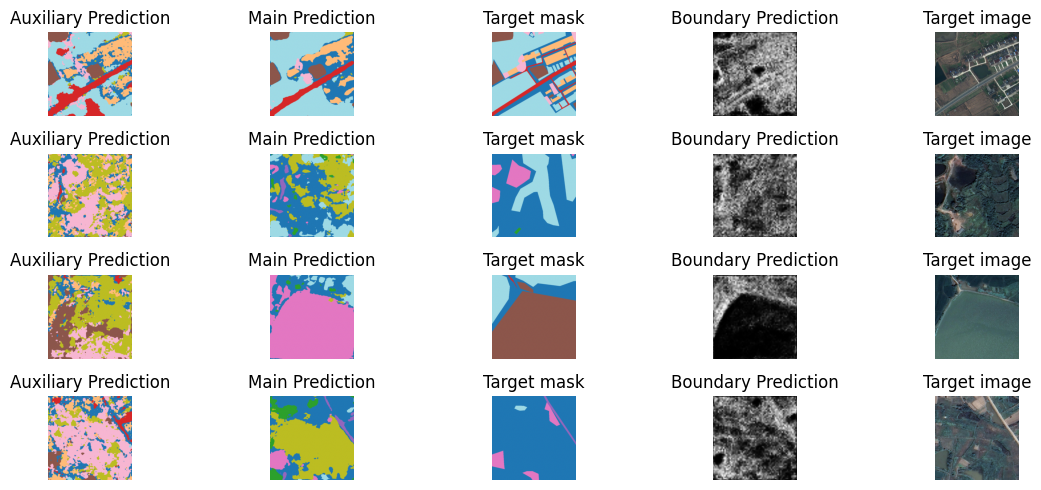

tensor(0.2753, device='cuda:0')
Validation Loss: 8.785358844264861 | mIoU: 0.2752849757671356 | Total validation samples seen: 992
  → background IoU: 0.3816
  → building IoU: 0.2334
  → road IoU: 0.2772
  → water IoU: 0.4621
  → barren IoU: 0.0998
  → forest IoU: 0.1220
  → agriculture IoU: 0.3509


In [51]:
# ****************************** Validazione ******************************
from torchmetrics.segmentation import MeanIoU

num_classes = 7
miou_classes = MeanIoU(num_classes=num_classes, input_format = "index", per_class=True).to(device)
miou_overall = MeanIoU(num_classes=num_classes).to(device)

model.eval()
val_loss = 0
miou_classes.reset()
total_val_samples = 0

with torch.inference_mode():
    for batch, (X_val, y_val, boundary_mask) in enumerate(val_loader):
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        boundary_mask = boundary_mask.to(device)

        # Output del modello
        outputs = model(X_val)

        #upscaling
        pred_p, pred_main, boundary_head = Upscaling(outputs=outputs, boundary_mask=boundary_mask, model=model)

        if batch == 0:
          fig, axs = plt.subplots(4, 5, figsize=(12, 5))

          for j in range(4):

            axs[j, 0].imshow(pred_p[j].cpu().detach().argmax(dim=0).numpy(), cmap='tab20')
            axs[j, 0].set_title("Auxiliary Prediction")
            axs[j, 0].axis('off')

            axs[j, 1].imshow(pred_main[j].cpu().detach().argmax(dim=0).numpy(), cmap='tab20')
            axs[j, 1].set_title("Main Prediction")
            axs[j, 1].axis('off')

            axs[j, 2].imshow(y_val[j].cpu().detach().numpy(), cmap='tab20')
            axs[j, 2].set_title("Target mask")
            axs[j, 2].axis('off')

            axs[j, 3].imshow(boundary_head[j].cpu().detach().sigmoid().squeeze(0).numpy(), cmap='gray')
            axs[j, 3].set_title("Boundary Prediction")
            axs[j, 3].axis('off')

            axs[j, 4].imshow(X_val[j].cpu().detach().squeeze(0).numpy().transpose(1, 2, 0))
            axs[j, 4].set_title("Target image")
            axs[j, 4].axis('off')

          plt.tight_layout()
          plt.show()

        # Calcola la loss
        loss = loss_fn(pred_p, pred_main, y_val, boundary_head, boundary_mask)

        if LOSS_TYPE == "ohem":
            loss = loss.mean()

        val_loss += loss.item()

        total_val_samples += X_val.size(0)

        preds = pred_main.argmax(dim=1)
        valid_mask = (y_val >= 0) & (y_val < num_classes)
        preds_flat = preds[valid_mask]
        targets_flat = y_val[valid_mask]

        miou_classes.update(preds_flat, targets_flat)

        pbar_val.set_postfix({
            "Val_Loss": f"{val_loss / (batch+1):.4f}",
            "mIoU": f"{miou_classes.compute().mean():.4f}"
        })


avg_val_loss = val_loss / total_val_samples

miou_per_class = miou_classes.compute()
miou = miou_per_class.mean()

print(miou_per_class.mean())

print(f"Validation Loss: {avg_val_loss} | mIoU: {miou} | Total validation samples seen: {total_val_samples}")
# per class
for i, iou in enumerate(miou_per_class):
    class_name = list(sem_class_to_idx.keys())[list(sem_class_to_idx.values()).index(i)]
    print(f"  → {class_name} IoU: {iou:.4f}")



h: 512 | w: 512 | ph: 64 | pw: 64


FLOPs: 6.317 GFLOPs
Average inference latency is 0.015 seconds.


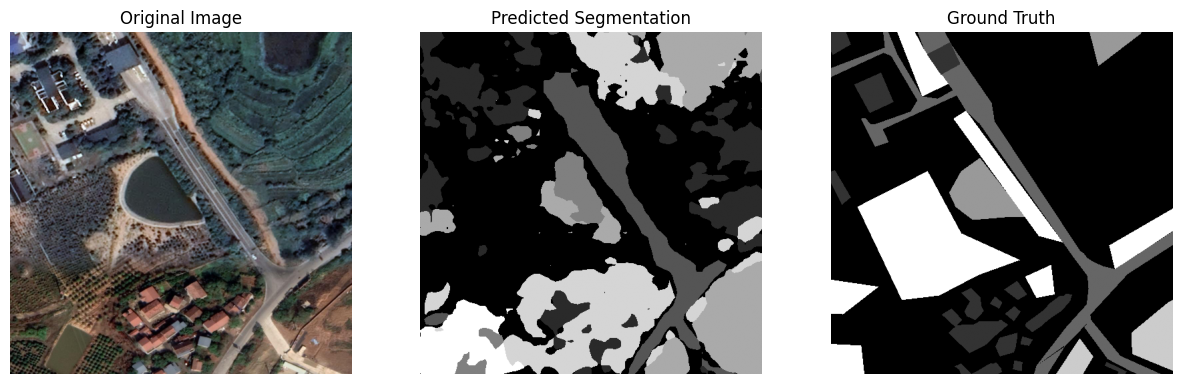

Params: 7.718 M


In [52]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from fvcore.nn import FlopCountAnalysis
import torch.nn.functional as F
import random

model.eval()  # Set model to evaluation mode

with torch.inference_mode():
    # Prendi un'immagine random dal validation set
    random_index = random.randint(0, len(val_dataset) - 1)
    X, y, boundary_mask = val_dataset[random_index]

    X = X.to(device).unsqueeze(dim=0)  # Aggiunge la dimensione batch
    y = y.to(device).unsqueeze(dim=0)
    boundary_mask = boundary_mask.to(device).unsqueeze(dim=0)

    start = timer()
    outputs = model(X)
    end = timer()

    latency = end - start

    ## Upscale trough bilinear interpolation
    h, w = boundary_mask.size(1), boundary_mask.size(2)
    ph, pw = outputs[0].size(2), outputs[0].size(3)
    print(f"h: {h} | w: {w} | ph: {ph} | pw: {pw}")
    if ph != h or pw != w:
        for i in range(len(outputs)):
            outputs[i] = F.interpolate(outputs[i], size=(h, w), mode='bilinear', align_corners=True)

    # Se augment=True, gestiamo i diversi output
    if model.augment:
        pred_p, pred_main, boundary_head = outputs
    else:
        pred_main = outputs
        boundary_head = None

    # Calcolo dei FLOPs
    flops = FlopCountAnalysis(model, X.clone())

    # Softmax per normalizzare le predizioni
    normalized_masks = torch.nn.functional.softmax(pred_main, dim=1)

    # Selezione delle predizioni per ciascuna classe
    masks = [
        normalized_masks[0, sem_class_to_idx[cls]]
        for cls in SEM_CLASSES
    ]

    print(f"FLOPs: {flops.total() / 1e9:.3f} GFLOPs")
    print(f"Average inference latency is {latency:.3f} seconds.")

    # Converti output e ground truth per la visualizzazione
    out = pred_main.squeeze().argmax(dim=0).cpu().numpy()  # Output segmentazione
    y_np = y.squeeze().cpu().numpy()  # Ground truth
    X_np = X.squeeze().cpu().permute(1, 2, 0).numpy()  # Immagine originale

    # Creazione della figura con tre immagini affiancate
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Immagine originale
    axes[0].imshow(X_np)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Predizione del modello
    axes[1].imshow(out, cmap="gray")
    axes[1].set_title("Predicted Segmentation")
    axes[1].axis("off")

    # Ground truth
    axes[2].imshow(y_np, cmap="gray")
    axes[2].set_title("Ground Truth")
    axes[2].axis("off")

    plt.show()

    # Conta i parametri del modello
    params = sum(p.numel() for p in model.parameters())
    print(f"Params: {params / 1e6:.3f} M")
